<a href="https://colab.research.google.com/github/Chengheri/text-classification-rnn/blob/master/imdb_pretrained_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMDB dataset: movie reviews from internet


*   **25,000 train samples**

> 12, 500 positive reviews

> 12, 500 negative reviews

*   **25,000 test samples**

> 12, 500 positive reviews

> 12, 500 negative *reviews*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Packages

In [2]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
from glob import glob

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Preparing the data

### Extracting text

In [0]:
def extract_text(data_type, label_type, verbose=1):
    """
    Given the data_type("train" or "test"), the label_type("neg" or "pos"), extract
    the raw text from each file and store them into 10 files. The reason of storing 
    by splitting into 10 files is that the extraction is too long. And if the processing fails,
    we can continue later from where it fails.
    """

    path = os.path.join(imdb_dir, data_type)
    dir_name = os.path.join(path, label_type)
    files = [file for file in os.listdir(dir_name) if file[-4:]=='.txt']
    num_samples = len(files)
    slice_idx = np.linspace(0, num_samples, 11)
    for i in range(len(slice_idx)-1):
        texts = []
        for fname in files[int(slice_idx[int(i)]):int(slice_idx[int(i)+1])]:
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())

        filename = path+'/'+label_type+str(i)+'.p'
        pickle.dump(texts, open(filename, "wb")) 
        if verbose:
            print("%s is saved" % filename)
    
    print("*"*50)
    print("Extraction is finished sucessfully.")
    print("*"*50)

In [0]:
imdb_dir = '/content/drive/My Drive/data/aclImdb'
#extract_text('train', 'neg', verbose=1)
#extract_text('train', 'pos')

### Loading data

In [0]:
def load_text(data_type, label_type):
    path = os.path.join(imdb_dir, data_type)
    texts = []
    for file in glob(path+'/'+label_type+'*.p'):
        texts += pickle.load(open(file, "rb"))

    return texts

In [0]:
train_neg = load_text('train', 'neg')
train_pos = load_text('train', 'pos')
train = train_neg + train_pos

In [0]:
labels_neg = [0] * 12500
labels_pos = [1] * 12500
labels = labels_neg + labels_pos

## Preprocessing

### Tokenization

In [0]:
def preprocess_texts(texts):
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) # turn into integer indices
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    # turn into 2D integer tensor of shape(samples, maxlen)
    data = pad_sequences(sequences, maxlen=maxlen) 
    print('Shape of data tensor:', data.shape)

    return data

In [0]:
def preprocess_labels(labels):
    
    labels = np.asarray(labels)
    print('Shape of label tensor:', labels.shape)
    
    return labels

In [38]:
#################### Tokenization #####################
maxlen = 100 # cuts off reviews after 100 words
max_words = 10000 # number of most frequent words considered as features

data_train = preprocess_texts(train)
labels_train = preprocess_labels(labels)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Train-validation split

In [0]:
training_samples = 200 
validation_samples = 10000

#################### train-validation split ####################
indices = np.arange(data.shape[0])
np.random.shuffle(indices) # shuffle data before splitting into training set and validation set
data_train = data[indices]
labels_train = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

### Word Embedding with pretrained embedding

In [41]:
glove_dir = '/content/drive/My Drive/data/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) # 100-dimensional embedding vectors for 400,000 words
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Defining a model - using pretrained embedding

In [0]:
 def get_model(): 

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    ############# Load GloVe embedding #################
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    return model
    

## Training the model

In [45]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 2.9912 - acc: 0.4150 - val_loss: 0.6933 - val_acc: 0.4998
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7220 - acc: 0.5800 - val_loss: 0.7078 - val_acc: 0.4977
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6091 - acc: 0.6550 - val_loss: 0.7252 - val_acc: 0.5068
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4573 - acc: 0.8100 - val_loss: 0.7594 - val_acc: 0.5009
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3296 - acc: 0.9050 - val_loss: 1.0322 - val_acc: 0.5077
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3724 - acc: 0.8200 - val_loss: 0.7546 - val_acc: 0.5311
Epoch 7/10
200/200 [==============================] - 1s 3ms/s

## Saving the model

In [0]:
models_dir = '/content/drive/My Drive/data/models/'
os.makedirs(models_dir, exist_ok=True)
model.save_weights(models_dir+'pre_trained_glove_model.h5')

## Performance monitoring

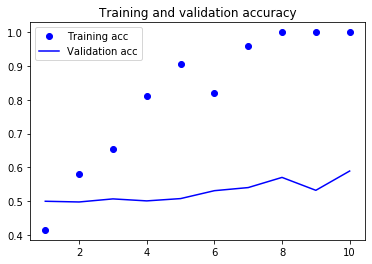

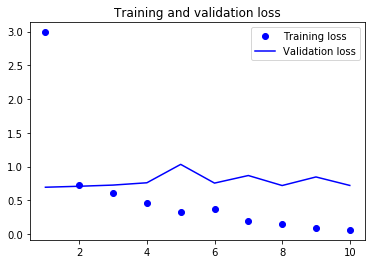

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Model evaluation

In [56]:
# extracting text
extract_text('test', 'neg')
extract_text('test', 'pos')

**************************************************
Extraction is finished sucessfully.
**************************************************
**************************************************
Extraction is finished sucessfully.
**************************************************


In [0]:
# merging
test_neg = load_text('test', 'neg')
test_pos = load_text('test', 'pos')
test = test_neg + test_pos

labels_neg = [0] * 12500
labels_pos = [1] * 12500
labels = labels_neg + labels_pos

In [59]:
# preprocessing (texts to tokens (tokenize) --> texts/tokens to sequences --> sequences to tensors (padding))
data_test = preprocess_texts(test)
labels_test = preprocess_labels(labels)

Found 87393 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [74]:
model = get_model()
model.load_weights(models_dir+'pre_trained_glove_model.h5')
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
loss, acc = model.evaluate(data_test, labels_test)
print("Test loss: %s" % loss)
print("Test accuracy: %s" % acc)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_10 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
25000/25000 [==============================] - 1s 58us/step
Test loss: 0.7924347104072571
Test accuracy: 0.5228
